# Evaluating the Results



## Quick look at the data

Just as a quick reference to remember which columns are available.
Double check for stupid mistakes.

In [1]:
import pandas as pd
from _conf import SIMPLIFIED_RESULTS, PUBLIC_DATA

# Load data and perform basic preprocessing
results = pd.read_json(SIMPLIFIED_RESULTS)

# Rename strategies to be more readable
strategy_names = {
    "GurobiTspSolver": "Dantzig (Gurobi)",
    "CpSatTspSolverV1": "AddCircuit",
    "CpSatTspSolverDantzig": "Iterative Dantzig",
    "CpSatTspSolverMtz": "Miller-Tucker-Zemlin",
}
results = results.replace({"strategy": strategy_names})

# Extract the relevant information
results = results.sort_values(["instance_name", "strategy"])
results["runtime"] = results["runtime"].apply(lambda x: min(x, 90))

# Keep track of the num_nodes column as it's used in later cells
results = results[results["opt_tol"] == 0.001].drop(
    columns=["opt_tol", "time_limit", "num_nodes"]
)
results = results[
    results["strategy"].isin(["Iterative Dantzig", "Miller-Tucker-Zemlin"])
]
print(results.set_index("instance_name").to_markdown())

| instance_name   | strategy             |   runtime |        objective |   lower_bound |
|:----------------|:---------------------|----------:|-----------------:|--------------:|
| att48           | Iterative Dantzig    |  89.8327  |  33522           |         33522 |
| att48           | Miller-Tucker-Zemlin |  90       |  33522           |         33369 |
| eil101          | Iterative Dantzig    |  90       |    629           |           629 |
| eil101          | Miller-Tucker-Zemlin |  43.8567  |    629           |           629 |
| eil51           | Iterative Dantzig    |  84.8225  |    426           |           426 |
| eil51           | Miller-Tucker-Zemlin |   3.05334 |    426           |           426 |
| eil76           | Iterative Dantzig    |  90       |    538           |           538 |
| eil76           | Miller-Tucker-Zemlin |   4.09839 |    538           |           538 |
| gil262          | Iterative Dantzig    |  90       |  13817           |          2368 |
| gil262  

In [2]:
# Add a virtual best solver for comparison
virtual_best = (
    results.groupby("instance_name")
    .agg({"objective": "min", "runtime": "min", "lower_bound": "max"})
    .reset_index()
)
virtual_best["strategy"] = "[Virtual Best]"
results = pd.concat([results, virtual_best], ignore_index=True).drop_duplicates()
results = results.sort_values(["instance_name", "strategy"])
print(results.set_index("instance_name").to_markdown())

| instance_name   | strategy             |   runtime |        objective |   lower_bound |
|:----------------|:---------------------|----------:|-----------------:|--------------:|
| att48           | Iterative Dantzig    |  89.8327  |  33522           |         33522 |
| att48           | Miller-Tucker-Zemlin |  90       |  33522           |         33369 |
| att48           | [Virtual Best]       |  89.8327  |  33522           |         33522 |
| eil101          | Iterative Dantzig    |  90       |    629           |           629 |
| eil101          | Miller-Tucker-Zemlin |  43.8567  |    629           |           629 |
| eil101          | [Virtual Best]       |  43.8567  |    629           |           629 |
| eil51           | Iterative Dantzig    |  84.8225  |    426           |           426 |
| eil51           | Miller-Tucker-Zemlin |   3.05334 |    426           |           426 |
| eil51           | [Virtual Best]       |   3.05334 |    426           |           426 |
| eil76   

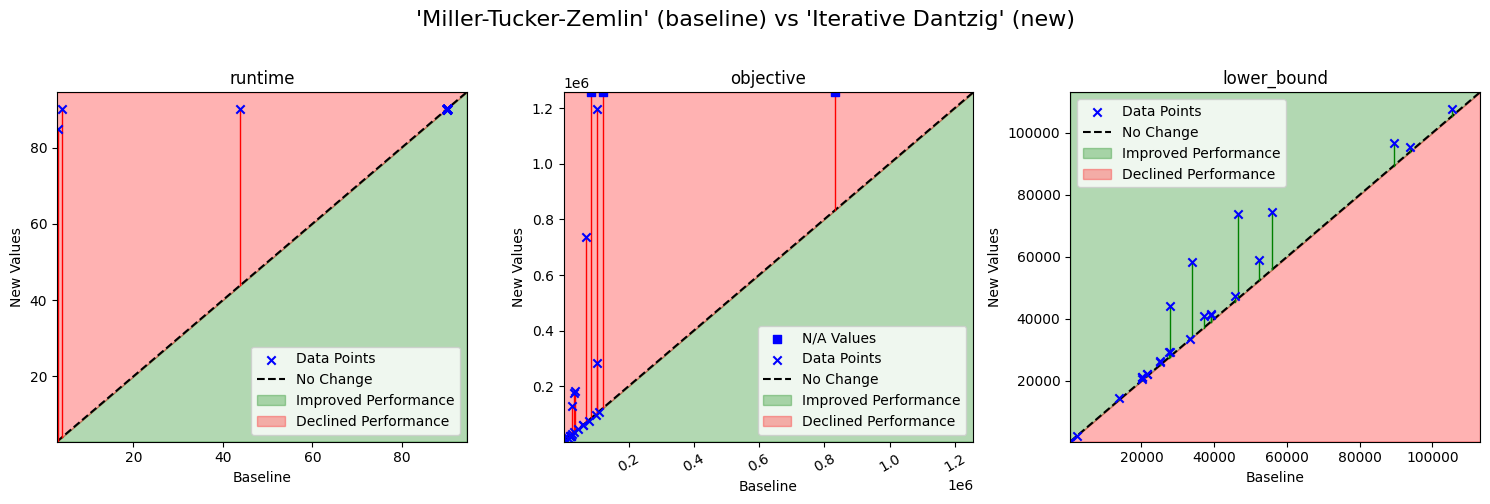

In [3]:
from scatter_with_performance_zones import plot_comparison_grid

baseline = "Miller-Tucker-Zemlin"
new = "Iterative Dantzig"
A = results[results["strategy"] == baseline].set_index("instance_name")
B = results[results["strategy"] == new].set_index("instance_name")

fig, axes = plot_comparison_grid(
    baseline_data=A,
    new_data=B,
    metrics=[("runtime", "min"), ("objective", "min"), ("lower_bound", "max")],
    suptitle=f"'{baseline}' (baseline) vs '{new}' (new)",
)
# rotate the second plot's x-axis labels for better readability
axes[1].tick_params(axis="x", rotation=30)

Skipping AddCircuit as it is not present in the results.


Skipping Dantzig (Gurobi) as it is not present in the results.


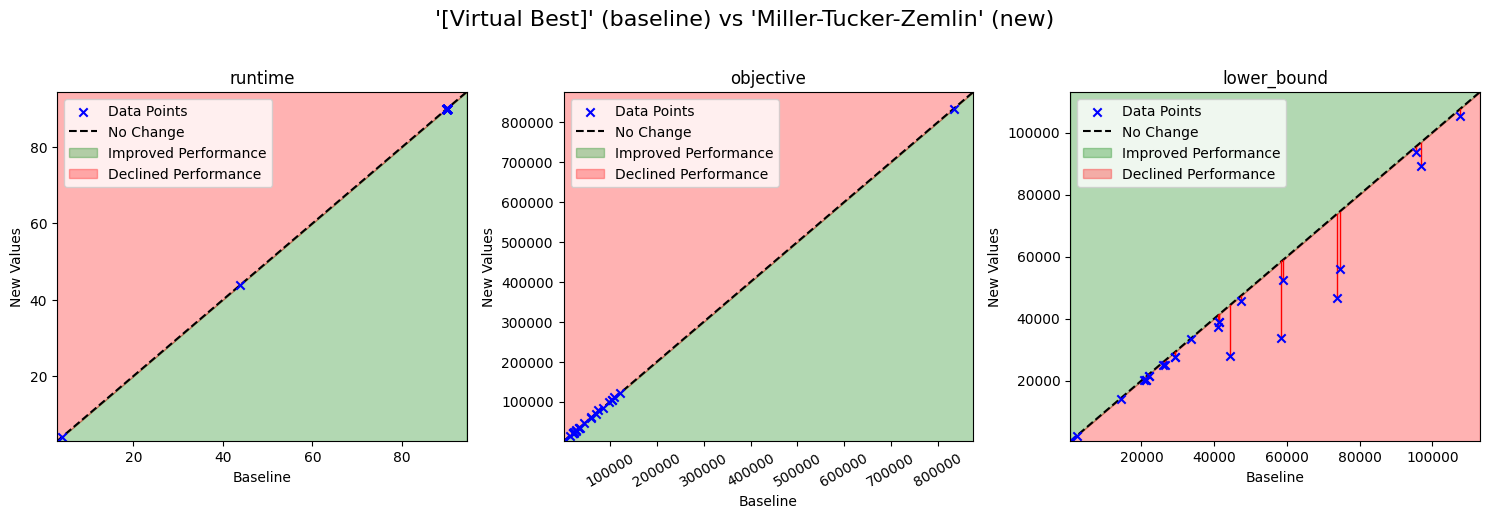

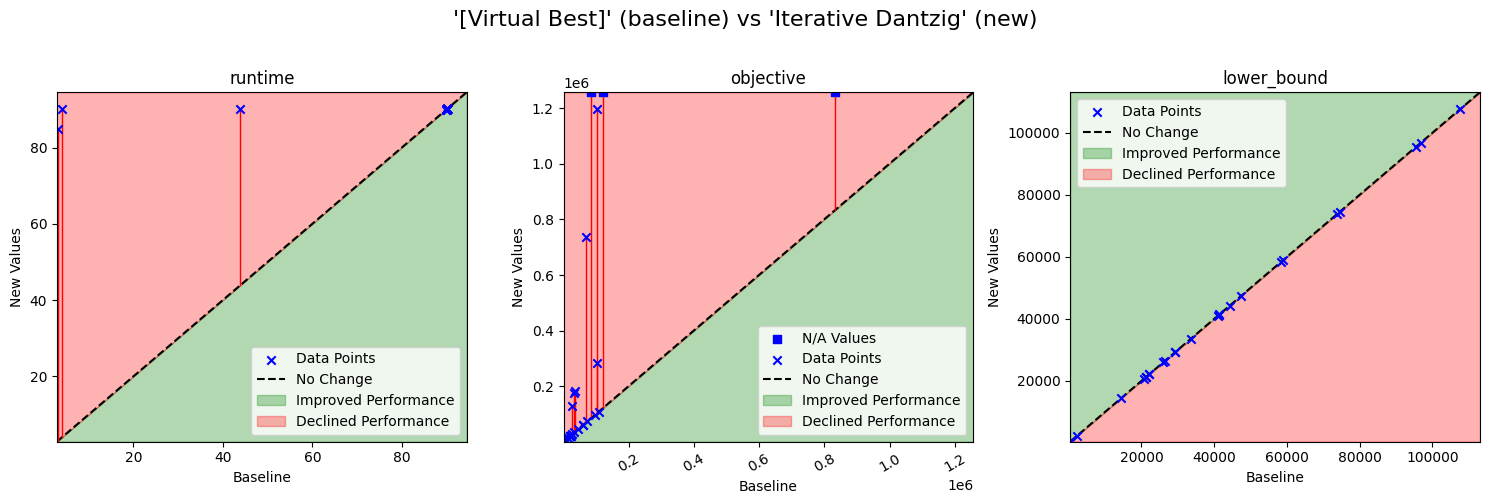

In [4]:
from scatter_with_performance_zones import plot_comparison_grid

baseline = "[Virtual Best]"
for new in [
    "AddCircuit",
    "Miller-Tucker-Zemlin",
    "Iterative Dantzig",
    "Dantzig (Gurobi)",
]:
    if new not in results["strategy"].unique():
        print(f"Skipping {new} as it is not present in the results.")
        continue

    A = results[results["strategy"] == baseline].set_index("instance_name")
    B = results[results["strategy"] == new].set_index("instance_name")

    fig, axes = plot_comparison_grid(
        baseline_data=A,
        new_data=B,
        metrics=[("runtime", "min"), ("objective", "min"), ("lower_bound", "max")],
        suptitle=f"'{baseline}' (baseline) vs '{new}' (new)",
    )
    # rotate the second plot's x-axis labels for better readability
    axes[1].tick_params(axis="x", rotation=30)

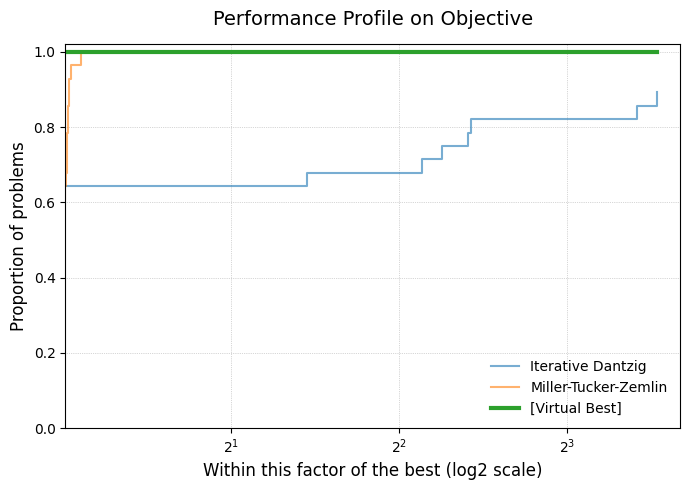

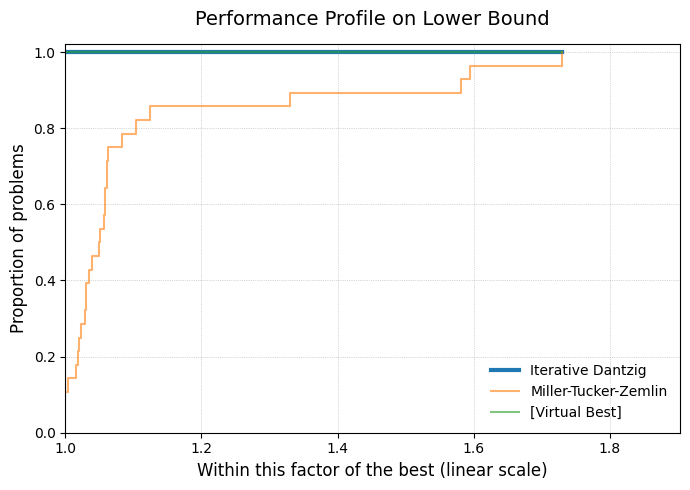

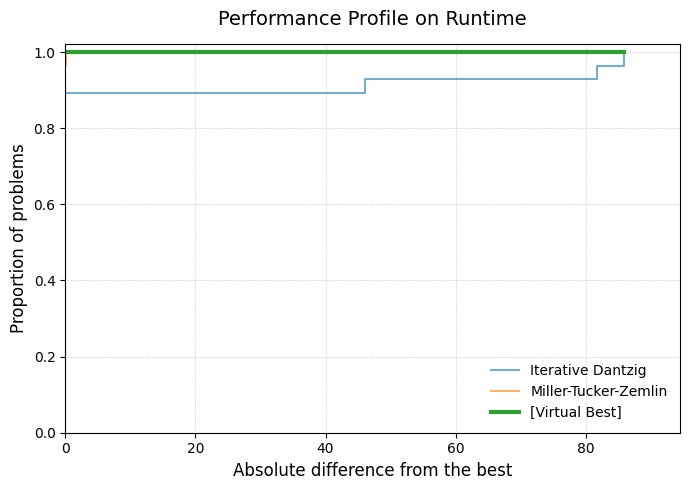

In [5]:
from performance_profile import plot_performance_profile
import matplotlib.pyplot as plt
# Example usage:
# ax = plot_performance(
#     results,
#     instance_column="instance_name",
#     strategy_column="strategy",
#     metric_column="objective",
#     direction="min",
#     title="Performance Profile on Objective"
# )
# plt.show()

ax = plt.figure(figsize=(7, 5)).gca()
plot_performance_profile(
    results,
    instance_column="instance_name",
    strategy_column="strategy",
    metric_column="objective",
    direction="min",
    highlight_best=True,
    ax=ax,
    title="Performance Profile on Objective",
)
plt.show()

# lower bound profile
ax = plt.figure(figsize=(7, 5)).gca()
plot_performance_profile(
    results,
    instance_column="instance_name",
    strategy_column="strategy",
    metric_column="lower_bound",
    direction="max",
    highlight_best=True,
    ax=ax,
    title="Performance Profile on Lower Bound",
)
plt.show()

# runtime profile
ax = plt.figure(figsize=(7, 5)).gca()
plot_performance_profile(
    results,
    instance_column="instance_name",
    strategy_column="strategy",
    metric_column="runtime",
    direction="min",
    highlight_best=True,
    ax=ax,
    comparison="absolute",
    title="Performance Profile on Runtime",
)
plt.show()

In [6]:
t = results.sort_values(["num_nodes", "instance_name"])
t[t["opt_tol"] == 0.001]

KeyError: 'num_nodes'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

## Looking at the runtime

We can take a quick look at the runtime of the different models.
This is a good sanity check to see if the models are actually running.
However, you will notice the sigmoidal shape of the runtime.
The instances do not suddenly get easier, but the runtime is limited by the timeout.
The true runtime can be expected to be an exponential curve.
For this reason, this is not a good metric to compare the models and may be misleading.

runtime
num_nodes strategy                        
48        AddCircuit              0.466354
          Dantzig (Gurobi)        0.094591
          Iterative Dantzig      89.832668
          Miller-Tucker-Zemlin   90.130786
51        AddCircuit              0.690657
...                                    ...
318       Miller-Tucker-Zemlin  222.491643
439       AddCircuit             94.220632
          Dantzig (Gurobi)       78.487351
          Iterative Dantzig      94.878760
          Miller-Tucker-Zemlin  185.639632

[80 rows x 1 columns]

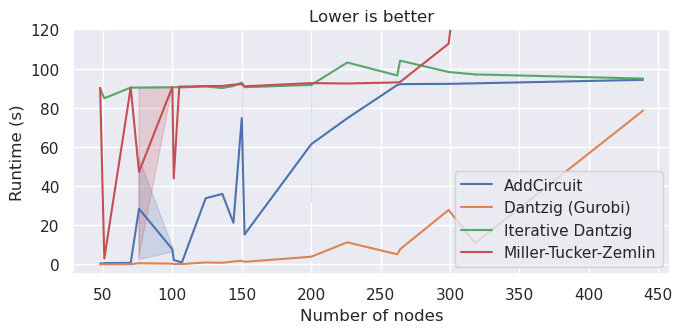

In [ ]:
from IPython.display import display

t = results.sort_values(["num_nodes", "instance_name"])
t = t[t["opt_tol"] == 0.001]
display(t.groupby(["num_nodes", "strategy"])[["runtime"]].mean())
plt.figure(figsize=(7, 3.5))
sns.lineplot(data=t.sort_values("strategy"), x="num_nodes", y="runtime", hue="strategy")
plt.ylabel("Runtime (s)")
plt.title("Lower is better")
plt.legend(loc="lower right")
plt.xlabel("Number of nodes")
plt.ylim(-5, 120)
plt.tight_layout()
plt.savefig(PUBLIC_DATA / "runtime.png")
plt.show()

## Plotting how many instances could still be solved to optimality

This is a more interesting metric.
Suddenly, we also see some differences between the `CpSatTspSolverMtz` and `CpSatTspSolverDantzig` models.


opt_perc
num_nodes strategy                      
48        AddCircuit               100.0
          Dantzig (Gurobi)         100.0
          Iterative Dantzig        100.0
          Miller-Tucker-Zemlin       0.0
51        AddCircuit               100.0
...                                  ...
318       Miller-Tucker-Zemlin       0.0
439       AddCircuit                 0.0
          Dantzig (Gurobi)         100.0
          Iterative Dantzig          0.0
          Miller-Tucker-Zemlin       0.0

[80 rows x 1 columns]

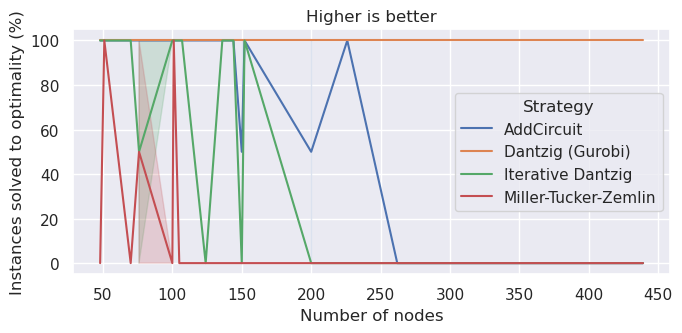

In [ ]:
t = results.sort_values(["num_nodes", "instance_name"])
t = t[t["opt_tol"] == 0.001]
t["opt_perc"] = t["opt"] * 100
display(t.groupby(["num_nodes", "strategy"])[["opt_perc"]].mean())
plt.figure(figsize=(7, 3.5))
t.rename(columns={"strategy": "Strategy"}, inplace=True)
sns.lineplot(
    data=t.sort_values("Strategy"), x="num_nodes", y="opt_perc", hue="Strategy"
)
plt.ylabel("Instances solved to optimality (%)")
plt.xlabel("Number of nodes")
plt.title("Higher is better")
plt.tight_layout()
plt.savefig(PUBLIC_DATA / "solved_over_size.png")
plt.show()

However, getting nearly optimal solutions is often signficantly easier than getting optimal solutions.
For this reason, we may also want to check if the performance changes when we relax the optimality tolerance.
Often, the data is inaccurate anyway, such that a 5% or even 20% optimality gap can be acceptable.
We actually see that the `CpSatTspSolvingMtz` is better than `CpSatTspSolvingDantzig` for a 20% optimality gap.
Also the `CpSatTspSolvingV1` model can solve significantly larger models if we relax the optimality tolerance.

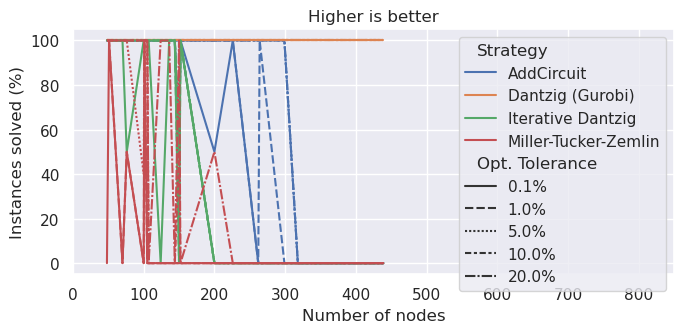

In [ ]:
# Same plot but this time use the best lower bound available for each instance.
opt_gaps = [0.001, 0.01, 0.05, 0.1, 0.2]
data = []
for opt_gap in opt_gaps:
    t = results[results["opt_tol"] == 0.001].copy()
    t["opt_gap"] = (t["objective"] - t["lower_bound"]) / t["lower_bound"]
    t["succ"] = t["opt_gap"] <= opt_gap
    t["Opt. Tolerance"] = f"{100 * opt_gap}%"
    t["opt_tol"] = opt_gap
    data.append(t)
t = pd.concat(data)
t["succ_perc"] = t["succ"] * 100
plt.figure(figsize=(7, 3.5))
t.rename(columns={"strategy": "Strategy"}, inplace=True)
sns.lineplot(
    data=t.sort_values(["Strategy", "opt_tol"]),
    x="num_nodes",
    y="succ_perc",
    hue="Strategy",
    style="Opt. Tolerance",
    errorbar=None,
)
plt.ylabel("Instances solved (%)")
plt.xlabel("Number of nodes")
plt.xlim(0, 850)
plt.title("Higher is better")
plt.tight_layout()
plt.savefig(PUBLIC_DATA / "solved_over_size_opt_tol.png")
plt.show()

A further point to consider is that the optimality gap is always calculated based on the own lower bound.
If we need solutions with a quality estimate, this is the way to go.
If we do not need the quality estimate, we can also use the best lower bound of all solvers to get a better estimate on the real optimality gap.
This is what we do in the next section.
The decision on which bound to use depends on the use case.

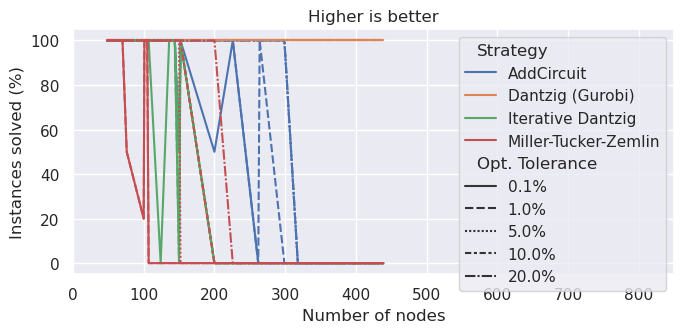

In [ ]:
# Same plot but this time use the best lower bound available for each instance.
opt_gaps = [0.001, 0.01, 0.05, 0.1, 0.2]
data = []
best_lb = results.groupby(["instance_name"])[["lower_bound"]].max().reset_index()
for opt_gap in opt_gaps:
    t = (
        results[results["opt_tol"] == 0.001]
        .merge(best_lb, on="instance_name", suffixes=("", "_best_lb"))
        .copy()
    )
    t["opt_gap"] = (t["objective"] - t["lower_bound_best_lb"]) / t[
        "lower_bound_best_lb"
    ]
    t["succ"] = t["opt_gap"] <= opt_gap
    t["Opt. Tolerance"] = f"{100 * opt_gap}%"
    t["opt_tol"] = opt_gap
    data.append(t)
t = pd.concat(data)
t["succ_perc"] = t["succ"] * 100
plt.figure(figsize=(7, 3.5))
t.rename(columns={"strategy": "Strategy"}, inplace=True)
sns.lineplot(
    data=t.sort_values(["Strategy", "opt_tol"]),
    x="num_nodes",
    y="succ_perc",
    hue="Strategy",
    style="Opt. Tolerance",
    errorbar=None,
)
plt.ylabel("Instances solved (%)")
plt.xlabel("Number of nodes")
plt.xlim(0, 850)
plt.title("Higher is better")
plt.tight_layout()
plt.savefig(PUBLIC_DATA / "solved_over_size_opt_tol_best_lb.png")
plt.show()

## Comparing on unstructured benchmarks

The line plots above need a well structured benchmark to compute reliable data points.
If you do not have such a benchmark, you may want to go for the following plot which shows how many instances of the benchmark could be solved within a given time limit.
This also gives an insight into how fast the model can deal with simple instances.
In this specific case, we see that the `CpSatTspSolvingMtz` can solve more instances than `CpSatTspSolvingDantzig`, but `CpSatTspSolvingDantzig` is usually faster for the instances it can solve.


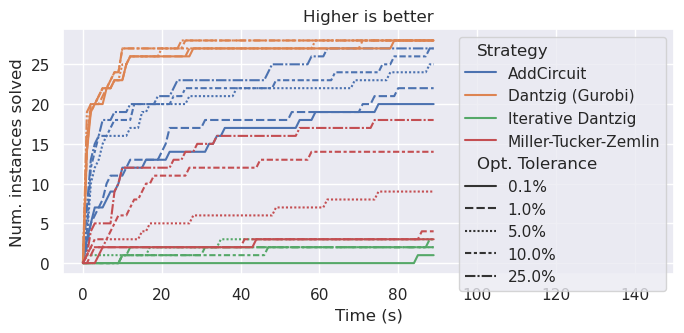

In [ ]:
from _conf import TIME_LIMIT, OPTIMALITY_TOLERANCES

time_steps = [t_ for t_ in range(0, TIME_LIMIT)]
filtered_results = results[results["opt_gap"] <= 1.001 * results["opt_tol"]].copy()


def f(strategy, at_time, tol):
    t = filtered_results[filtered_results["strategy"] == strategy]
    t = t[t["runtime"] <= at_time]
    t = t[t["opt_tol"] == tol]
    t.drop_duplicates(subset=["instance_name"], inplace=True)
    return len(t)


data = {
    "Strategy": [],
    "x": [],
    "time": [],
    "Opt. Tolerance": [],
    "opt_tol": [],
}

for strateg in results["strategy"].unique().tolist():
    for time in time_steps:
        for tol in OPTIMALITY_TOLERANCES:
            data["Strategy"].append(strateg)
            data["x"].append(time)
            data["time"].append(f(strateg, time, tol))
            data["Opt. Tolerance"].append(f"{tol * 100}%")
            data["opt_tol"].append(tol)
t = pd.DataFrame(data)
plt.figure(figsize=(7, 3.5))
sns.lineplot(
    data=t.sort_values(["Strategy", "opt_tol"]),
    x="x",
    y="time",
    hue="Strategy",
    style="Opt. Tolerance",
    errorbar=None,
)
plt.ylabel("Num. instances solved")
plt.xlim(-5, 150)
plt.xlabel("Time (s)")
plt.title("Higher is better")
plt.tight_layout()
plt.savefig(PUBLIC_DATA / "cactus_plot_opt_tol.png")
plt.show()

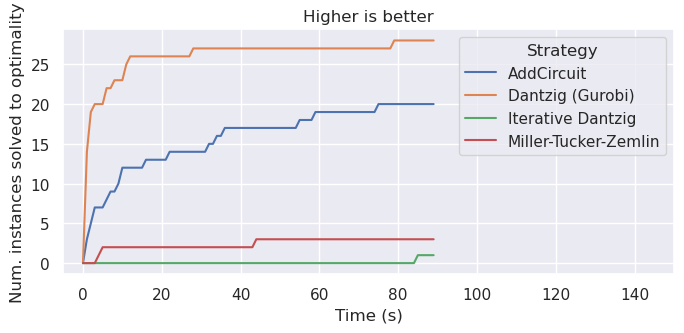

In [ ]:
from _conf import TIME_LIMIT, OPTIMALITY_TOLERANCES

time_steps = [t_ for t_ in range(0, TIME_LIMIT)]
filtered_results = results[results["opt_gap"] <= 1.001 * results["opt_tol"]].copy()


def f(strategy, at_time, tol):
    t = filtered_results[filtered_results["strategy"] == strategy]
    t = t[t["runtime"] <= at_time]
    t = t[t["opt_tol"] == tol]
    t.drop_duplicates(subset=["instance_name"], inplace=True)
    return len(t)


data = {
    "Strategy": [],
    "x": [],
    "time": [],
    "Opt. Tolerance": [],
}

for strateg in results["strategy"].unique().tolist():
    for time in time_steps:
        for tol in OPTIMALITY_TOLERANCES[:1]:
            data["Strategy"].append(strateg)
            data["x"].append(time)
            data["time"].append(f(strateg, time, tol))
            data["Opt. Tolerance"].append(tol * 100)
t = pd.DataFrame(data)
plt.figure(figsize=(7, 3.5))
sns.lineplot(
    data=t.sort_values("Strategy"), x="x", y="time", hue="Strategy", errorbar=None
)
plt.ylabel("Num. instances solved to optimality")
plt.xlim(-5, 150)
plt.xlabel("Time (s)")
plt.title("Higher is better")
plt.tight_layout()
plt.savefig(PUBLIC_DATA / "cactus_plot.png")
plt.show()

In [ ]:
# to markdown
print(
    results[(results["opt_tol"] == 0.001) & (results["strategy"] == "AddCircuit")]
    .groupby(["instance_name"])[
        ["num_nodes", "runtime", "lower_bound", "objective", "opt_gap"]
    ]
    .mean()
    .round(2)
    .sort_values("num_nodes")
    .to_markdown()
)

| instance_name   |   num_nodes |   runtime |   lower_bound |   objective |   opt_gap |
|:----------------|------------:|----------:|--------------:|------------:|----------:|
| att48           |          48 |      0.47 |         33522 |       33522 |      0    |
| eil51           |          51 |      0.69 |           426 |         426 |      0    |
| st70            |          70 |      0.8  |           675 |         675 |      0    |
| eil76           |          76 |      2.49 |           538 |         538 |      0    |
| pr76            |          76 |     54.36 |        108159 |      108159 |      0    |
| kroD100         |         100 |      9.72 |         21294 |       21294 |      0    |
| kroC100         |         100 |      5.57 |         20749 |       20749 |      0    |
| kroB100         |         100 |      6.2  |         22141 |       22141 |      0    |
| kroE100         |         100 |      9.06 |         22049 |       22068 |      0    |
| kroA100         |         100 